## Spatial analysis of Zurich

We implement spatial analysis to extract relevant information from the association of Zurich zip-code level averaged insurance data metrics with the indicators for the city of Zurich previously constructed.

In [52]:
import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
import pysal as ps
import seaborn as sns

In [81]:
DATA_FOLDER = "./data/"

#read zips geometry data
zips = gpd.read_file( DATA_FOLDER + "shapeFiles/zips.shp")
zips.columns = ['UUID', 'OS_UUID', 'STATUS', 'INAEND', 'ZIP', 'ZUSZIFF','geometry']

# read data previously cleaned, aggregated and merged
zurich_indicators_df = pd.read_csv(DATA_FOLDER + 'zurich_indicators.csv', index_col=0)
insurance_avg_df = pd.read_csv(DATA_FOLDER + 'zurich_insurance_averages.csv', index_col=0)
insurance_jobs_avg_df = pd.read_csv(DATA_FOLDER + 'insurance_jobs_avgs.csv', index_col=0)

display(zurich_indicators_df.head())
display(insurance_avg_df.head())
display(insurance_jobs_avg_df.head())

,safety_indic,hospitality_indic,handicapp_indic,parks_indic,pf_indic,cc_indic,sf_indic,cf_indic
8050,0.030897,-0.004573,0.057086,-0.010871,-0.069738,-0.006650,0.026753,0.060253
8049,-0.022621,-0.098503,-0.088325,-0.014034,-0.099443,-0.084240,-0.084932,-0.007254
8048,-0.023800,-0.033503,0.033034,-0.110341,-0.106258,-0.034871,0.132786,0.009932
8032,0.000955,-0.059359,-0.023114,-0.072792,-0.007547,-0.062333,-0.110309,0.005162
8046,-0.032635,-0.098414,-0.102853,-0.057837,-0.149956,-0.007862,-0.000254,-0.010371


,Avg_Children_0-26,Avg_Car_Premium,Avg_num_cars,Avg_total_car_spending,Avg_property_premium,Avg_Age,Avg_Stand_of_furn,Avg_Rooms
8001,0.114327,246.777135,0.159190,8719.247467,135399.421129,52.795948,0.626628,1.008683
8002,0.159195,289.970082,0.208600,9797.804209,117795.974382,47.647758,0.731016,1.372827
8003,0.091236,156.687635,0.146459,5384.153661,60006.402561,41.789516,0.821529,1.521409
8004,0.100722,154.187402,0.140409,5134.395670,60840.950090,42.186109,0.682502,1.269092
8005,0.142173,186.035184,0.158449,6700.813787,77629.487793,42.348492,0.779799,1.502633


,%JobState_Angestellt,%JobState_Arbeitslos,%JobState_Hausfrau,%JobState_Rentner,%JobState_Selbstständig,%JobState_Student,%JobState_Unknown
8001_,62.373372,0.434153,1.013025,12.445731,9.985528,4.486252,9.261939
8002_,67.795059,0.000000,1.372370,9.789570,4.757548,4.117109,12.168344
8003_,74.709884,0.280112,0.320128,4.161665,3.601441,7.963185,8.963585
8004_,72.609741,0.661455,0.601323,4.930848,3.908599,6.554420,10.733614
8005_,74.533270,0.574438,0.478698,2.967927,3.973193,4.882719,12.589756


In [94]:
# take only zips for insurance data
insurance_avg_zips_df = insurance_avg_df.drop(['Zurich'])
insurance_avg_zips_df.index=pd.to_numeric(insurance_avg_zips_df.index)

# merge the qol indicators and the insurance data
city_people_df = pd.merge(zurich_indicators_df,insurance_avg_zips_df, how='inner', left_index=True, right_index=True)

# add geometry information for each zip 
city_people_df = pd.merge(city_people_df, zips[['ZIP', 'geometry']].set_index('ZIP'), 'inner', left_index=True,right_index=True)
city_people_df = city_people_df.drop_duplicates('safety_indic')
city_people_df.index

Int64Index([8001, 8002, 8003, 8004, 8005, 8006, 8008, 8032, 8037, 8038, 8041,
            8044, 8045, 8046, 8047, 8048, 8049, 8050, 8051, 8052, 8053, 8055,
            8057, 8064],
           dtype='int64')

### Correlation between city and people metrics

In [49]:
# create spatial weights matrix
shapelist = city_people_df.geometry.tolist()
W = ps.weights.Queen.from_iterable(shapelist)

mi = ps.Moran(city_people_df.Avg_property_premium, W)
print(mi.I, mi.p_sim)



0.436207214802252 0.001


In [66]:
from scipy.stats import pearsonr

df1 = city_people_df.drop(columns='geometry')
df2 = city_people_df.drop(columns='geometry')

coeffmat = np.zeros((df1.shape[1], df2.shape[1]))
pvalmat = np.zeros((df1.shape[1], df2.shape[1]))

for i in range(df1.shape[1]):    
    for j in range(df2.shape[1]):        
        corrtest = pearsonr(df1[df1.columns[i]], df2[df2.columns[j]])  

        coeffmat[i,j] = corrtest[0]
        pvalmat[i,j] = corrtest[1]

dfcoeff = pd.DataFrame(coeffmat, columns=df2.columns, index=df1.columns)
display(dfcoeff)

dfpvals = pd.DataFrame(pvalmat, columns=df2.columns, index=df1.columns)
display(dfpvals)

,safety_indic,hospitality_indic,handicapp_indic,parks_indic,pf_indic,cc_indic,sf_indic,cf_indic,Avg_Children_0-26,Avg_Car_Premium,Avg_num_cars,Avg_total_car_spending,Avg_property_premium,Avg_Age,Avg_Stand_of_furn,Avg_Rooms
safety_indic,1.000000,0.929031,0.721115,0.122589,0.832447,-0.233822,-0.285127,-0.101938,-0.632905,-0.247975,-0.515654,-0.172164,-0.084181,-0.262194,-0.567045,-0.763483
hospitality_indic,0.929031,1.000000,0.707644,0.221076,0.894797,-0.147575,-0.211981,-0.180971,-0.590940,-0.256808,-0.503294,-0.194898,-0.090982,-0.181954,-0.564762,-0.792626
handicapp_indic,0.721115,0.707644,1.000000,0.281794,0.659321,-0.312795,-0.253309,-0.122656,-0.499796,-0.061487,-0.421947,0.088386,0.309874,-0.214639,-0.259826,-0.504020
parks_indic,0.122589,0.221076,0.281794,1.000000,0.425076,-0.059569,0.200759,0.238715,0.375022,0.340810,0.133903,0.374629,0.449285,0.468122,-0.040150,-0.095633
pf_indic,0.832447,0.894797,0.659321,0.425076,1.000000,-0.018336,-0.101416,-0.112853,-0.407916,-0.045045,-0.333960,0.017653,0.132233,0.128897,-0.502241,-0.744059
cc_indic,-0.233822,-0.147575,-0.312795,-0.059569,-0.018336,1.000000,0.602682,0.175309,0.252712,-0.052663,0.187254,-0.101949,-0.245504,0.211963,-0.276403,-0.058705
sf_indic,-0.285127,-0.211981,-0.253309,0.200759,-0.101416,0.602682,1.000000,0.182348,0.451902,0.369083,0.561244,0.304221,-0.180824,0.273155,-0.113955,0.167877
cf_indic,-0.101938,-0.180971,-0.122656,0.238715,-0.112853,0.175309,0.182348,1.000000,0.303263,-0.100783,0.007882,-0.150635,-0.239087,-0.055777,-0.211671,0.004144
Avg_Children_0-26,-0.632905,-0.590940,-0.499796,0.375022,-0.407916,0.252712,0.451902,0.303263,1.000000,0.587890,0.747446,0.509729,0.265630,0.573121,0.368393,0.663843
Avg_Car_Premium,-0.247975,-0.256808,-0.061487,0.340810,-0.045045,-0.052663,0.369083,-0.100783,0.587890,1.000000,0.889730,0.973521,0.597949,0.752023,0.437200,0.469034


,safety_indic,hospitality_indic,handicapp_indic,parks_indic,pf_indic,cc_indic,sf_indic,cf_indic,Avg_Children_0-26,Avg_Car_Premium,Avg_num_cars,Avg_total_car_spending,Avg_property_premium,Avg_Age,Avg_Stand_of_furn,Avg_Rooms
safety_indic,0.000000e+00,5.693796e-11,0.000070,0.568229,4.536709e-07,0.271476,0.176857,0.635521,0.000903,2.426733e-01,9.906652e-03,4.211448e-01,0.695738,0.215824,3.858976e-03,1.423632e-05
hospitality_indic,5.693796e-11,0.000000e+00,0.000110,0.299202,3.674367e-09,0.491355,0.320021,0.397405,0.002360,2.257489e-01,1.217398e-02,3.614392e-01,0.672439,0.394804,4.036979e-03,3.883670e-06
handicapp_indic,7.013626e-05,1.098508e-04,0.000000,0.182193,4.577101e-04,0.136696,0.232358,0.568016,0.012888,7.753281e-01,3.999540e-02,6.813004e-01,0.140594,0.313848,2.201515e-01,1.202984e-02
parks_indic,5.682293e-01,2.992016e-01,0.182193,0.000000,3.839123e-02,0.782167,0.346892,0.261282,0.070965,1.031635e-01,5.327673e-01,7.128461e-02,0.027630,0.021056,8.522343e-01,6.566690e-01
pf_indic,4.536709e-07,3.674367e-09,0.000458,0.038391,0.000000e+00,0.932228,0.637261,0.599560,0.047847,8.344472e-01,1.107339e-01,9.347498e-01,0.537935,0.548330,1.238534e-02,3.071065e-05
cc_indic,2.714761e-01,4.913552e-01,0.136696,0.782167,9.322284e-01,0.000000,0.001828,0.412580,0.233497,8.069261e-01,3.809388e-01,6.354852e-01,0.247551,0.320064,1.910587e-01,7.852545e-01
sf_indic,1.768568e-01,3.200208e-01,0.232358,0.346892,6.372614e-01,0.001828,0.000000,0.393763,0.026629,7.591755e-02,4.324674e-03,1.483648e-01,0.397794,0.196541,5.959782e-01,4.329737e-01
cf_indic,6.355207e-01,3.974054e-01,0.568016,0.261282,5.995604e-01,0.412580,0.393763,0.000000,0.149712,6.393738e-01,9.708416e-01,4.823137e-01,0.260517,0.795741,3.207463e-01,9.846657e-01
Avg_Children_0-26,9.028042e-04,2.360262e-03,0.012888,0.070965,4.784693e-02,0.233497,0.026629,0.149712,0.000000,2.518388e-03,2.699044e-05,1.094551e-02,0.209648,0.003417,7.650938e-02,4.048026e-04
Avg_Car_Premium,2.426733e-01,2.257489e-01,0.775328,0.103164,8.344472e-01,0.806926,0.075918,0.639374,0.002518,0.000000e+00,6.015839e-09,1.367878e-15,0.002029,0.000023,3.265078e-02,2.077318e-02


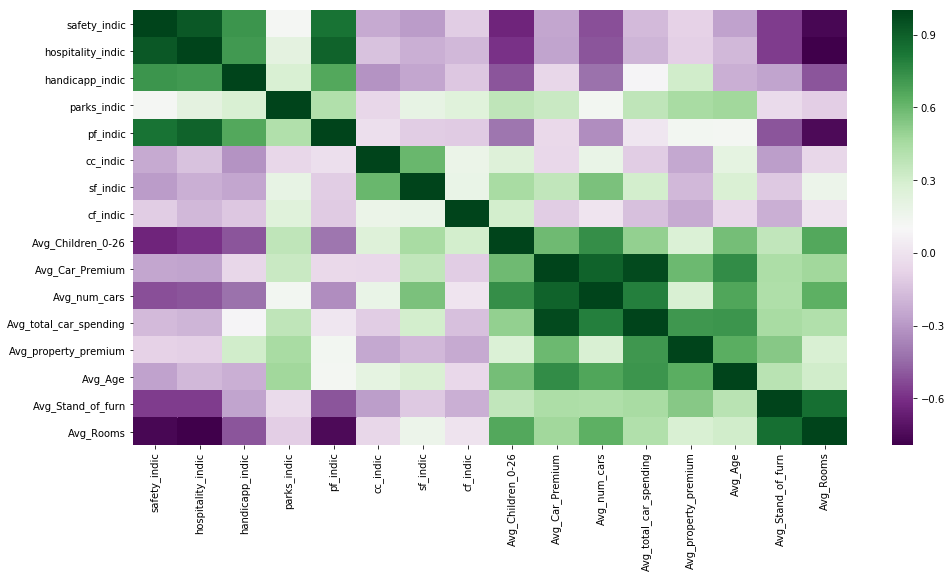

In [67]:
f, ax = plt.subplots(figsize=(16, 8))
sns.heatmap(dfcoeff, 
        xticklabels=dfcoeff.columns,
        yticklabels=dfcoeff.columns, cmap='PRGn')


### Corrrelation between city metrics and customer jobs info


In [87]:
insurance_jobs_avg_df2 = insurance_jobs_avg_df.drop(['Zurich_'])
insurance_jobs_avg_df2.index=insurance_jobs_avg_df2.index.map(lambda x: str(x).rstrip('_'))
insurance_jobs_avg_df2.index=pd.to_numeric(insurance_jobs_avg_df2.index)

city_jobs_df = pd.merge(zurich_indicators_df,insurance_jobs_avg_df2, how='inner', left_index=True, right_index=True)

# add geometry information for each zip 
city_jobs_df = pd.merge(city_jobs_df, zips[['ZIP', 'geometry']].set_index('ZIP'), 'inner', left_index=True,right_index=True)
city_jobs_df = city_jobs_df.drop_duplicates('safety_indic')

In [88]:
df1 = city_jobs_df.drop(columns='geometry')
df2 = city_jobs_df.drop(columns='geometry')

coeffmat = np.zeros((df1.shape[1], df2.shape[1]))
pvalmat = np.zeros((df1.shape[1], df2.shape[1]))

for i in range(df1.shape[1]):    
    for j in range(df2.shape[1]):        
        corrtest = pearsonr(df1[df1.columns[i]], df2[df2.columns[j]])  

        coeffmat[i,j] = corrtest[0]
        pvalmat[i,j] = corrtest[1]

dfcoeff = pd.DataFrame(coeffmat, columns=df2.columns, index=df1.columns)
display(dfcoeff)

dfpvals = pd.DataFrame(pvalmat, columns=df2.columns, index=df1.columns)
display(dfpvals)

,safety_indic,hospitality_indic,handicapp_indic,parks_indic,pf_indic,cc_indic,sf_indic,cf_indic,%JobState_Angestellt,%JobState_Arbeitslos,%JobState_Hausfrau,%JobState_Rentner,%JobState_Selbstständig,%JobState_Student,%JobState_Unknown
safety_indic,1.000000,0.929031,0.721115,0.122589,0.832447,-0.233822,-0.285127,-0.101938,0.191062,-0.007209,-0.378320,-0.399918,0.497702,0.312854,-0.115845
hospitality_indic,0.929031,1.000000,0.707644,0.221076,0.894797,-0.147575,-0.211981,-0.180971,0.142078,0.092390,-0.361029,-0.307845,0.523518,0.260491,-0.208452
handicapp_indic,0.721115,0.707644,1.000000,0.281794,0.659321,-0.312795,-0.253309,-0.122656,0.108844,-0.013219,-0.283229,-0.480455,0.629734,0.184383,0.117111
parks_indic,0.122589,0.221076,0.281794,1.000000,0.425076,-0.059569,0.200759,0.238715,-0.550599,0.332288,0.382760,0.319052,0.438307,-0.320619,0.068596
pf_indic,0.832447,0.894797,0.659321,0.425076,1.000000,-0.018336,-0.101416,-0.112853,-0.133551,-0.072932,-0.231429,-0.032316,0.660608,0.094043,-0.263324
cc_indic,-0.233822,-0.147575,-0.312795,-0.059569,-0.018336,1.000000,0.602682,0.175309,-0.021708,0.032428,-0.168986,0.447891,-0.287844,-0.073601,-0.472379
sf_indic,-0.285127,-0.211981,-0.253309,0.200759,-0.101416,0.602682,1.000000,0.182348,-0.129752,0.272181,0.236448,0.540292,-0.384398,-0.266131,-0.378947
cf_indic,-0.101938,-0.180971,-0.122656,0.238715,-0.112853,0.175309,0.182348,1.000000,0.067430,0.308272,0.161820,0.050442,-0.322924,-0.481698,0.253837
%JobState_Angestellt,0.191062,0.142078,0.108844,-0.550599,-0.133551,-0.021708,-0.129752,0.067430,1.000000,0.065821,-0.609651,-0.741678,-0.438079,0.591496,-0.233800
%JobState_Arbeitslos,-0.007209,0.092390,-0.013219,0.332288,-0.072932,0.032428,0.272181,0.308272,0.065821,1.000000,0.182785,0.010642,-0.318149,-0.102022,0.036900


,safety_indic,hospitality_indic,handicapp_indic,parks_indic,pf_indic,cc_indic,sf_indic,cf_indic,%JobState_Angestellt,%JobState_Arbeitslos,%JobState_Hausfrau,%JobState_Rentner,%JobState_Selbstständig,%JobState_Student,%JobState_Unknown
safety_indic,0.000000e+00,5.693796e-11,0.000070,0.568229,4.536709e-07,0.271476,0.176857,0.635521,0.371150,0.973331,0.068322,0.052833,0.013332,0.136617,0.589854
hospitality_indic,5.693796e-11,0.000000e+00,0.000110,0.299202,3.674367e-09,0.491355,0.320021,0.397405,0.507808,0.667650,0.083048,0.143349,0.008655,0.218931,0.328332
handicapp_indic,7.013626e-05,1.098508e-04,0.000000,0.182193,4.577101e-04,0.136696,0.232358,0.568016,0.612669,0.951115,0.179884,0.017484,0.000975,0.388413,0.585770
parks_indic,5.682293e-01,2.992016e-01,0.182193,0.000000,3.839123e-02,0.782167,0.346892,0.261282,0.005302,0.112642,0.064885,0.128606,0.032163,0.126635,0.750117
pf_indic,4.536709e-07,3.674367e-09,0.000458,0.038391,0.000000e+00,0.932228,0.637261,0.599560,0.533853,0.734858,0.276551,0.880840,0.000442,0.662045,0.213781
cc_indic,2.714761e-01,4.913552e-01,0.136696,0.782167,9.322284e-01,0.000000,0.001828,0.412580,0.919802,0.880433,0.429897,0.028176,0.172588,0.732513,0.019762
sf_indic,1.768568e-01,3.200208e-01,0.232358,0.346892,6.372614e-01,0.001828,0.000000,0.393763,0.545657,0.198205,0.265974,0.006420,0.063651,0.208757,0.067828
cf_indic,6.355207e-01,3.974054e-01,0.568016,0.261282,5.995604e-01,0.412580,0.393763,0.000000,0.754237,0.142767,0.449988,0.814931,0.123775,0.017153,0.231352
%JobState_Angestellt,3.711497e-01,5.078082e-01,0.612669,0.005302,5.338526e-01,0.919802,0.545657,0.754237,0.000000,0.759929,0.001563,0.000034,0.032263,0.002332,0.271522
%JobState_Arbeitslos,9.733305e-01,6.676500e-01,0.951115,0.112642,7.348576e-01,0.880433,0.198205,0.142767,0.759929,0.000000,0.392610,0.960637,0.129751,0.635240,0.864082


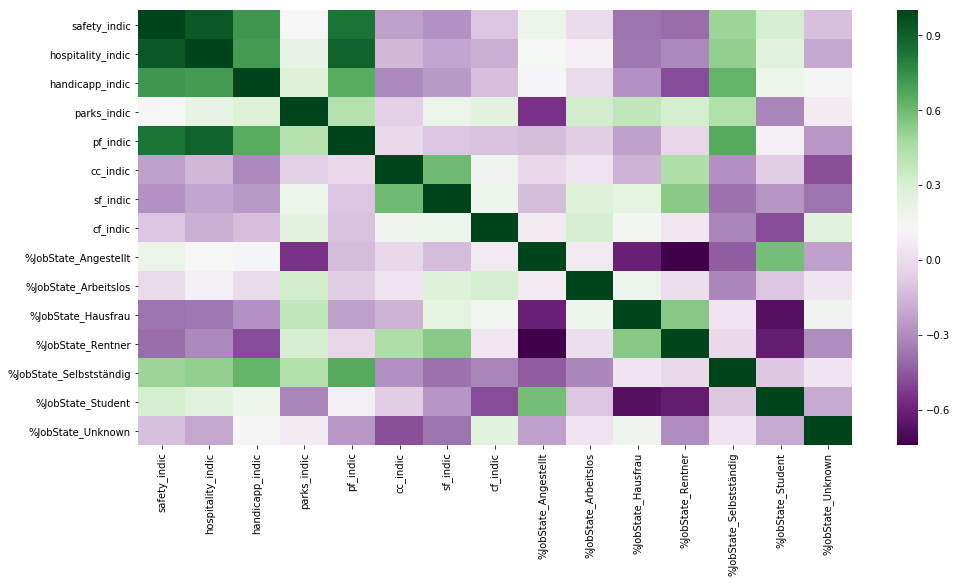

In [89]:
f, ax = plt.subplots(figsize=(16, 8))
sns.heatmap(dfcoeff, 
        xticklabels=dfcoeff.columns,
        yticklabels=dfcoeff.columns, cmap='PRGn')


## Visualizing correlations

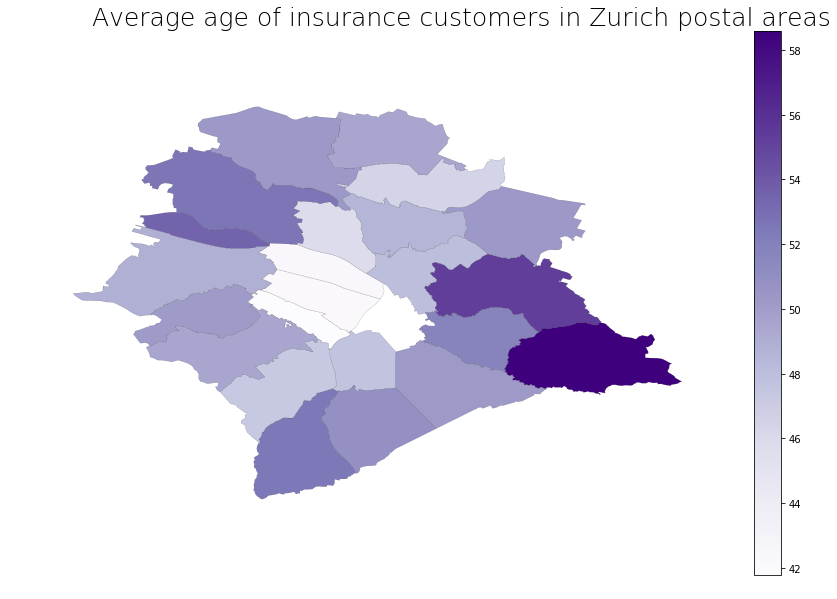

In [63]:
def display_map(gp, col_to_plot,title,colormap):
    '''
    This function creates a choropleth map using geopandas
    
    Parameters:
    gp = geodataframe data containing geometry column
    col_to_plot = column of data that must be plotted
    title = title of the map
    colormap = plt colormap to use, e.g. 'Blues', 'Accent', ...
    '''
    f, ax = plt.subplots(figsize=(15, 10))
    
    from mpl_toolkits.axes_grid1 import make_axes_locatable

    # Create colorbar
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.2)
    
    # plotting settings
    ax.set_title(title, fontdict={'fontsize': '25', 'fontweight' : '3'})
    ax.set_aspect('equal')
    cax.set_aspect('equal')
    cax.set_axis_off()
    ax.set_axis_off()

    # get preferred colormap
    cmap = plt.cm.get_cmap(colormap)
    
    # plot data
    gp.plot(column=col_to_plot, ax=cax, linewidth=0.1, edgecolor='black',cmap=cmap)
    
    # create colorbar
    norm=plt.Normalize(vmin=gp[col_to_plot].min(), vmax=gp[col_to_plot].max())
    sm = plt.cm.ScalarMappable(cmap=cmap,norm=norm)
    sm._A = []
    f.colorbar(sm)

city_people_df2=city_people_df.drop([8001])
    
# use function defined above to create choropleth map 
display_map(gpd.GeoDataFrame(city_people_df2), 'Avg_Age', 'Average age of insurance customers in Zurich postal areas','Purples')

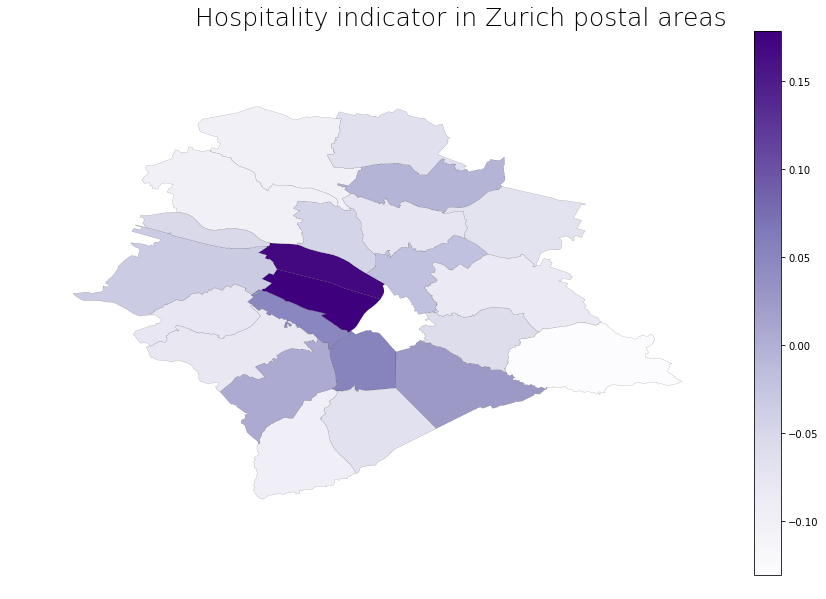

In [64]:
display_map(gpd.GeoDataFrame(city_people_df2), 'hospitality_indic', 'Hospitality indicator in Zurich postal areas','Purples')

### Linking the people to the city

Now that we have constructed metrics that characterize the city and obtained information about its citizens, we want to link the people to the area that they live in, and understand what are the factors that lead to them living there. We have gathered a lot of features and metrics so far, and there is a lot of information to be extracted. We chose to focalize our spatial analysis to a few points that really stand out. To reveal these elements, we first examine which features correlate to each other. The following heatmap shows the Pearson correlation coefficient between all of the indicators and some mean insurance data features (aggregated to zip code level).

Some remarks concerning this heatmap:
- All of the mean insurance customer metrics seem to be positively correlated together. This should be expected, as older customers should earn more, have more cars and larger houses on average.
- Some of the city indicators are positively correlated together. For instance the safety indicator seems to be quite strongly positvely correlated to the hospitality one.
- We see some counterintuitive behavior: the average number of rooms is strongly negatively correlated to the safety indicator. Upon further analysis, and when considering how the safety indicator was constructed, it seems that this safety score is actually measuring proximity to the center. The majority of the police locations are situated in the center of Zurich, and the number of street lights follows a similar pattern. This does not however mean that the suburban postal areas are less safe.


We can however notice the following information which seems to be relevant:
- Young people tend to be in areas with more hospitality companies, and 
